In [101]:
#library(zoo)
library(glue)
library(dplyr)
#library(rstan)
library(tidyr)
library(ggplot2)
#library(ggrepel)
library(ggthemes)
library(lubridate)
library(tidyverse)
#library(flexdashboard)
library(futile.logger)

# load code from other files in this package
source("globals.R")

In [102]:
df_bw <- read_csv("https://raw.githubusercontent.com/aarora79/biomettracker/master/data/Amit.csv") %>%
  mutate(Date=ymd(Date), Weight=as.numeric(Weight))
head(df_bw)
df_deadlifts <- read_csv("https://raw.githubusercontent.com/aarora79/biomettracker/master/raw_data/Amit_deadlifts.csv") %>%
  mutate(date=ymd(date))
head(df_deadlifts)


── Column specification ────────────────────────────────────────────────────────
cols(
  Date = col_character(),
  Weight = col_character(),
  BMI = col_character(),
  `Body Fat` = col_character(),
  `Lean Mass` = col_character(),
  `Muscle Percentage` = col_character(),
  `Water Percentage` = col_character()
)


Warning message:
“ 2 failed to parse.”
Warning message in mask$eval_all_mutate(quo):
“NAs introduced by coercion”


Date,Weight,BMI,Body Fat,Lean Mass,Muscle Percentage,Water Percentage
<date>,<dbl>,<chr>,<chr>,<chr>,<chr>,<chr>
2021-09-10,186.95,28.3,NA,186.95,NA,NA
2021-09-09,188.27,28.5,NA,188.27,NA,NA
2021-09-08,188.27,28.5,27.0,137.44,39.2,53.3
2021-09-07,190.26,28.8,27.3,138.32,39.1,53.1
2021-09-06,186.29,28.2,NA,186.29,NA,NA
2021-09-05,185.19,28.1,NA,185.19,NA,NA



── Column specification ────────────────────────────────────────────────────────
cols(
  date = col_character(),
  excercise = col_character(),
  set = col_double(),
  reps = col_double(),
  weight = col_double()
)




date,excercise,set,reps,weight
<date>,<chr>,<dbl>,<dbl>,<dbl>
2021-09-06,deadlift & carry,1,3,225
2021-09-06,deadlift & carry,2,3,235
2021-09-06,deadlift & carry,3,3,245
2021-09-06,deadlift & carry,4,3,255
2021-09-01,deadlift,1,5,235
2021-09-01,deadlift,2,5,255


In [103]:
# get the max deadlift on a particular data
df_deadlifts_only <- df_deadlifts %>%
  filter(excercise == "deadlift")

head(df_deadlifts_only)

date,excercise,set,reps,weight
<date>,<chr>,<dbl>,<dbl>,<dbl>
2021-09-01,deadlift,1,5,235
2021-09-01,deadlift,2,5,255
2021-09-01,deadlift,3,5,275
2021-09-01,deadlift,4,3,295
2021-09-01,deadlift,4,3,305
2021-09-01,deadlift,4,3,315


In [104]:
df_deadlift_max <- df_deadlifts_only %>%
  group_by(date) %>%
  summarize(weight = max(weight, na.rm=TRUE)) %>%
  arrange(desc(date))

head(df_deadlift_max, 40)

date,weight
<date>,<dbl>
2021-09-01,325
2021-08-25,305
2021-08-18,305
2021-08-04,235
2021-07-28,305
2021-07-21,325
2021-07-14,295
2021-07-07,295
2021-07-01,235


In [105]:
# join with the weight data
df_deadlift_and_bodyweight <- df_deadlift_max %>%
  left_join(df_bw %>% select(Date, Weight) %>% 
            rename(bodyweight=Weight), by=c("date" = "Date")) %>%
  mutate(dl_to_bw_ratio = round(weight/bodyweight, 4))

head(df_deadlift_and_bodyweight, 5)

date,weight,bodyweight,dl_to_bw_ratio
<date>,<dbl>,<dbl>,<dbl>
2021-09-01,325,185.80,1.7492
2021-08-25,305,184.75,1.6509
2021-08-18,305,192.90,1.5811
2021-08-04,235,186.51,1.2600
2021-07-28,305,185.41,1.6450


`geom_smooth()` using method = 'loess' and formula 'y ~ x'



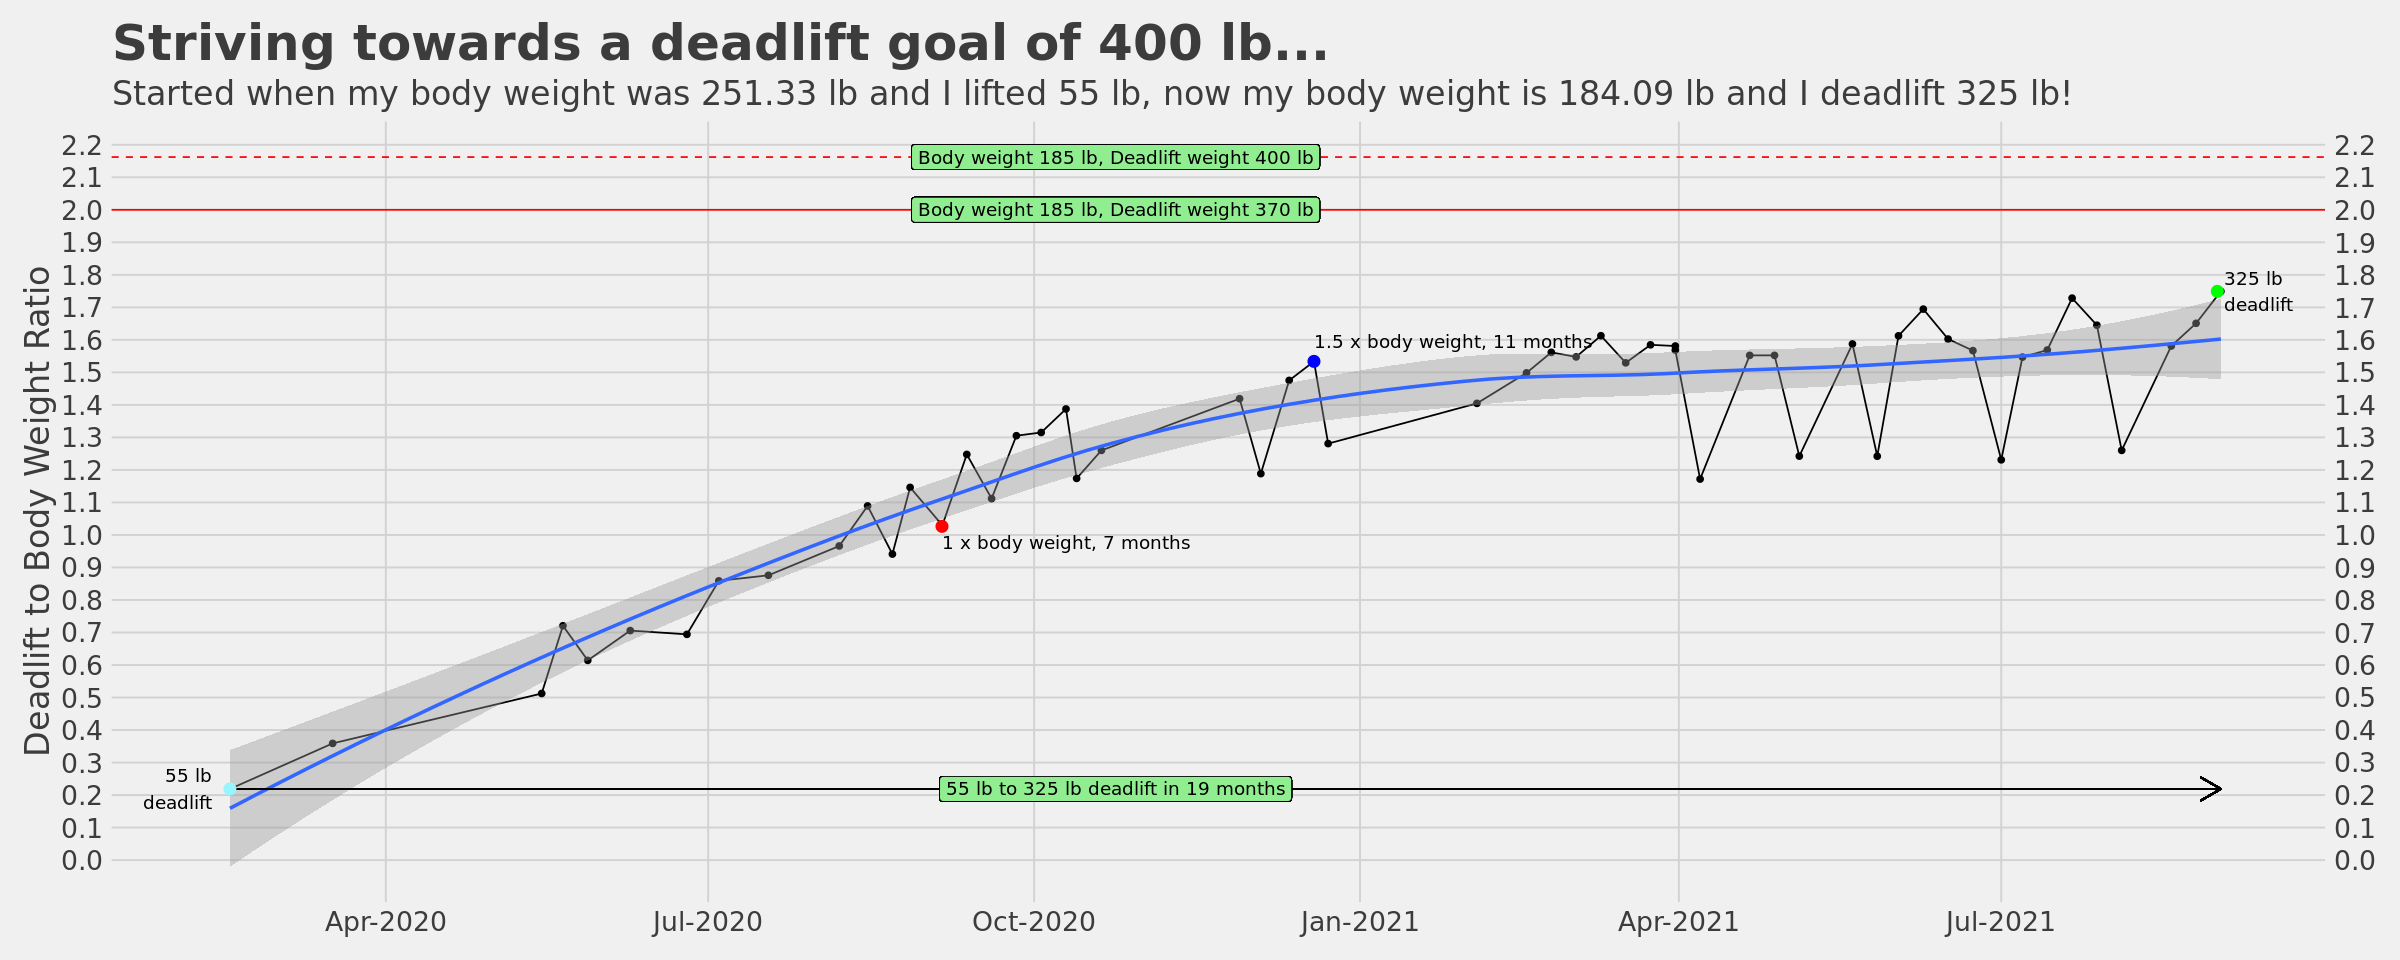

In [106]:
title <- "Striving towards a deadlift goal of 400 lb..."
maxbw <- max(df_deadlift_and_bodyweight$bodyweight)
minbw <- min(df_deadlift_and_bodyweight$bodyweight)

maxdl <- max(df_deadlift_and_bodyweight$weight)
mindl <- min(df_deadlift_and_bodyweight$weight)

subtitle <- glue("Started when my body weight was {maxbw} lb and I lifted {mindl} lb, now my body weight is {minbw} lb and I deadlift {maxdl} lb!")
journey_text <- glue("{min(df_deadlift_and_bodyweight$weight)} lb to {max(df_deadlift_and_bodyweight$weight)} lb deadlift in {ceiling(difftime(max(df_deadlift_and_bodyweight$date), min(df_deadlift_and_bodyweight$date), units='days')/30)} months")

options(repr.plot.width=20, repr.plot.height=8)
RATIO_GOAL <- 2
RATIO_STRETCH_GOAL <- 400/185
two_x_text <- glue("Body weight 185 lb, Deadlift weight 370 lb")
fh_text <- glue("Body weight 185 lb, Deadlift weight 400 lb")

p <- df_deadlift_and_bodyweight %>%
  ggplot(aes(x=date, y=dl_to_bw_ratio)) +
  geom_point() + 
  geom_line() +
  geom_hline(yintercept=RATIO_GOAL, color=I("red")) +
  geom_hline(yintercept=RATIO_STRETCH_GOAL, color=I("red"), linetype="dashed") +
  geom_smooth() +
  geom_segment(aes(x = min(date), y = min(dl_to_bw_ratio), xend = max(date), yend = min(dl_to_bw_ratio)), arrow = arrow(length = unit(0.5, "cm"))) +
  geom_label(aes(x = min(date)+250, y = RATIO_GOAL, label = two_x_text), fill = "lightgreen") +
  geom_label(aes(x = min(date)+250, y = RATIO_STRETCH_GOAL, label = fh_text), fill = "lightgreen") +
  geom_label(aes(x = min(date)+250, y = min(dl_to_bw_ratio), label = journey_text), fill = "lightgreen") +
  scale_y_continuous(breaks=seq(0, 2.5, 0.1), sec.axis = sec_axis(~ . * 1, breaks = seq(0, 2.5, 0.1))) +
  scale_x_date(date_breaks = "3 month", date_labels="%b-%Y") +
  theme_fivethirtyeight() + 
  labs(title=title,
       subtitle=subtitle) +
  theme(legend.position="none") +
  theme(axis.title = element_text(), axis.title.x = element_blank(), text = element_text(size=20)) + 
  xlab("") +
  ylab('Deadlift to Body Weight Ratio')
#p

one_bw_dl <- df_deadlift_and_bodyweight %>%
  filter(between(dl_to_bw_ratio, 1, 1.05)) %>%
  filter(date == min(date) & dl_to_bw_ratio == min(dl_to_bw_ratio))
months_to_one_x_bw_dl <- ceiling(difftime(one_bw_dl$date, min(df_deadlift_and_bodyweight$date), units="days")/30)

one_and_half_bw_dl <- df_deadlift_and_bodyweight %>%
  filter(between(dl_to_bw_ratio, 1.5, 1.55)) %>%
  filter(date == min(date))
months_to_one_and_half_bw_dl <- ceiling(difftime(one_and_half_bw_dl$date, min(df_deadlift_and_bodyweight$date), units="days")/30)

p +  
annotate(geom = "point", x = min(df_deadlift_and_bodyweight$date), y = min(df_deadlift_and_bodyweight$dl_to_bw_ratio), colour = "cadetblue1", size = 3) +
annotate(geom = "point", x = one_bw_dl$date, y = one_bw_dl$dl_to_bw_ratio, colour = "red", size = 3) +
annotate(geom = "text", x = one_bw_dl$date, y = one_bw_dl$dl_to_bw_ratio-0.05, , label = glue("1 x body weight, {months_to_one_x_bw_dl} months"), hjust = "left") +
annotate(geom = "text", x = one_and_half_bw_dl$date, y = one_and_half_bw_dl$dl_to_bw_ratio+0.06, , label = glue("1.5 x body weight, {months_to_one_and_half_bw_dl} months"), hjust = "left") +
annotate(geom = "point", x = one_and_half_bw_dl$date, y = one_and_half_bw_dl$dl_to_bw_ratio, colour = "blue", size = 3) +
annotate(geom = "point", x = max(df_deadlift_and_bodyweight$date)-1, y = max(df_deadlift_and_bodyweight$dl_to_bw_ratio), colour = "green", size = 3) +
annotate(geom = "text", x = max(df_deadlift_and_bodyweight$date)+1, y = max(df_deadlift_and_bodyweight$dl_to_bw_ratio), label = glue("{max(df_deadlift_and_bodyweight$weight)} lb\ndeadlift"), hjust = "left") +
annotate(geom = "text", x = min(df_deadlift_and_bodyweight$date)-5, y = min(df_deadlift_and_bodyweight$dl_to_bw_ratio), label = glue("{min(df_deadlift_and_bodyweight$weight)} lb\ndeadlift"), hjust = "right") 
#+
#annotate(geom = "text", x = min(df_deadlift_and_bodyweight$date)+250, y = min(df_deadlift_and_bodyweight$dl_to_bw_ratio)+0.1, label = journey_text, hjust = "center")




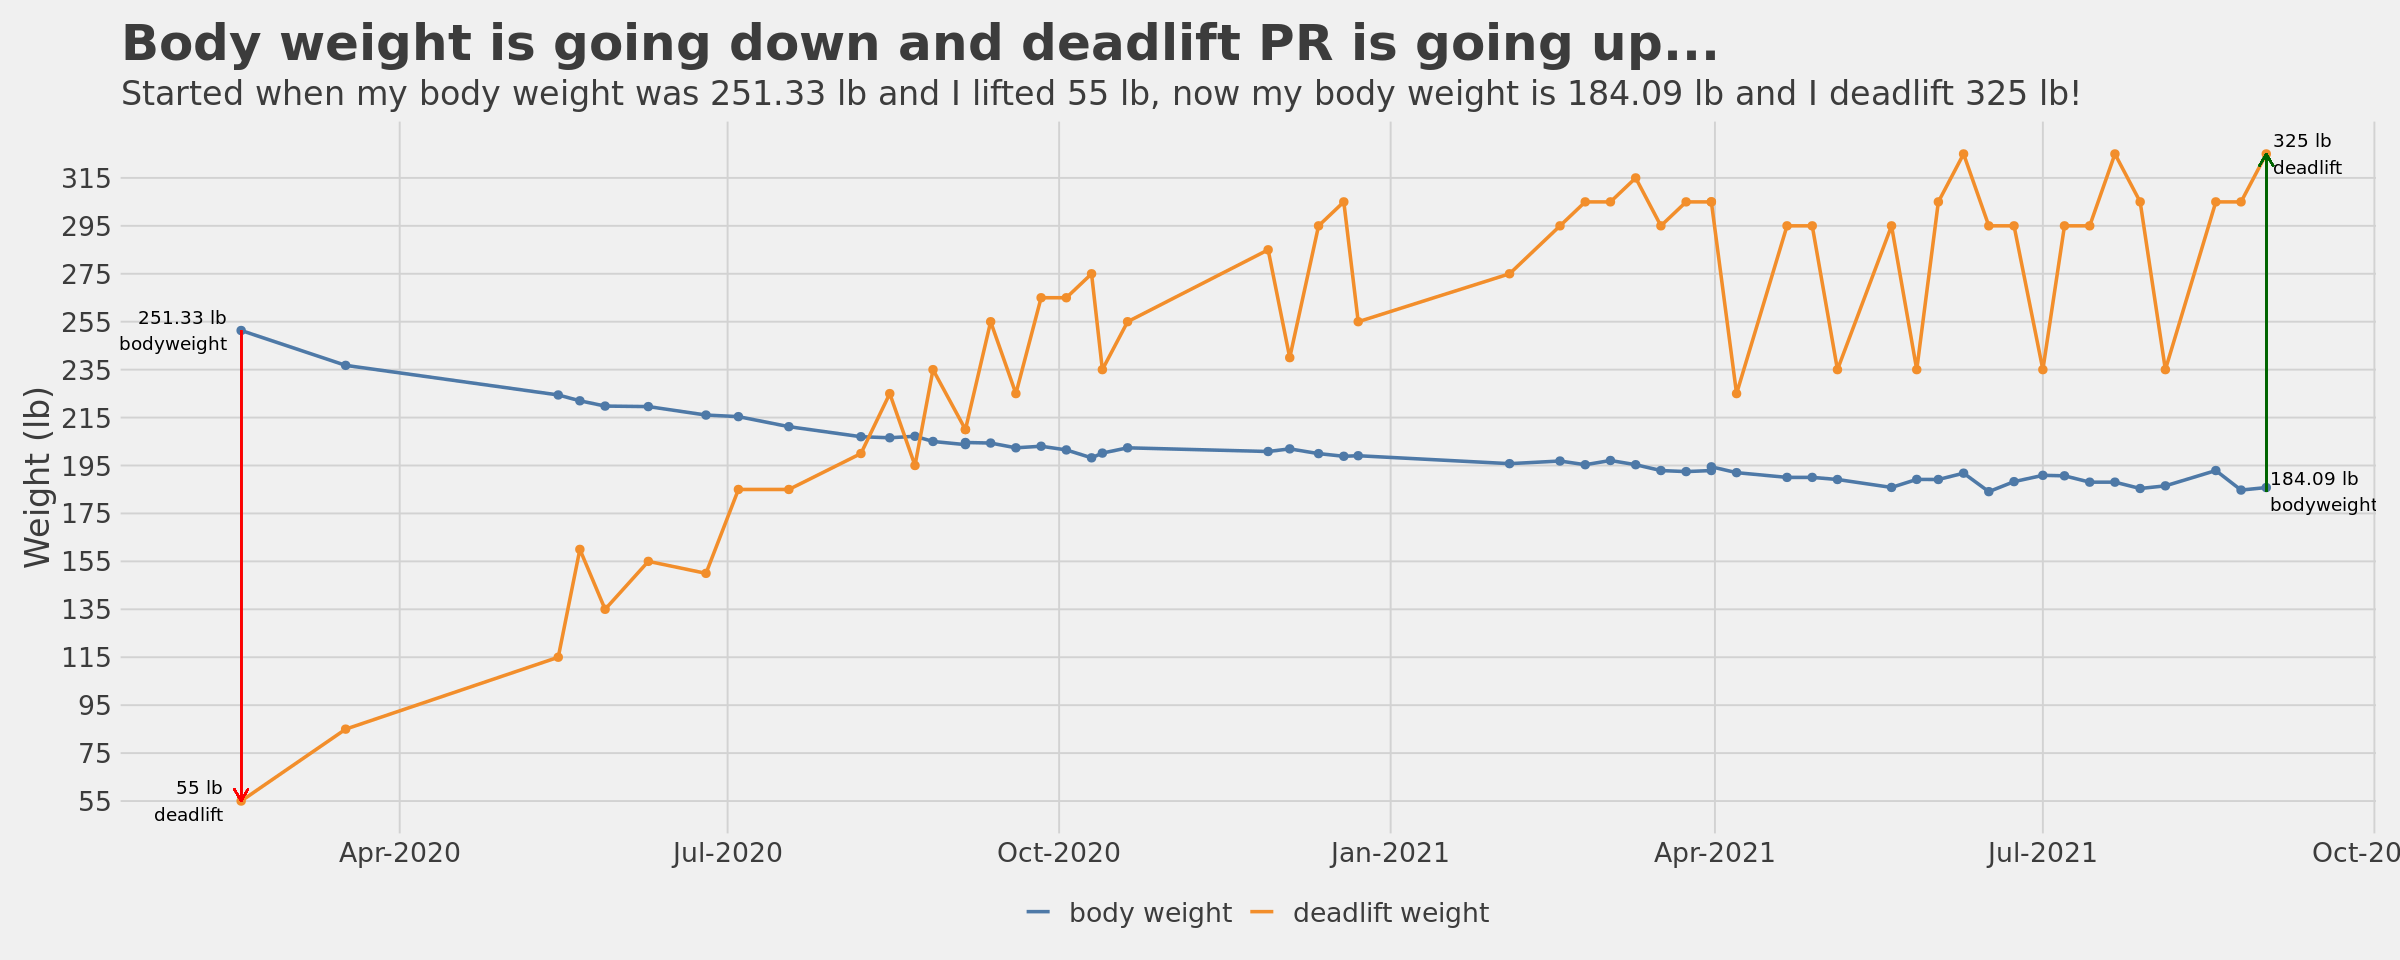

In [107]:
title <- "Body weight is going down and deadlift PR is going up..."
maxbw <- max(df_deadlift_and_bodyweight$bodyweight)
minbw <- min(df_deadlift_and_bodyweight$bodyweight)

maxdl <- max(df_deadlift_and_bodyweight$weight)
mindl <- min(df_deadlift_and_bodyweight$weight)

subtitle <- glue("Started when my body weight was {maxbw} lb and I lifted {mindl} lb, now my body weight is {minbw} lb and I deadlift {maxdl} lb!")

options(repr.plot.width=20, repr.plot.height=8)

df_dl_and_bw_tidy <- df_deadlift_and_bodyweight %>%
  select(-dl_to_bw_ratio) %>%
  rename(`deadlift weight`=weight, `body weight`=bodyweight) %>%
  gather(k, v, -date)

p <- df_dl_and_bw_tidy %>%
  ggplot(aes(x=date, y=v, col=k)) +
  geom_point(size=2, show.legend=FALSE) + 
  geom_line(size=1) +
  scale_y_continuous(breaks=seq(min(df_dl_and_bw_tidy$v), max(df_dl_and_bw_tidy$v), 20)) +
  scale_x_date(date_breaks = "3 month", date_labels="%b-%Y") +
  scale_color_tableau() +
  theme_fivethirtyeight() + 
  geom_segment(aes(xend = min(date), yend = min(df_deadlift_and_bodyweight$weight), x = min(date), y = max(df_deadlift_and_bodyweight$bodyweight)), arrow = arrow(length = unit(0.3, "cm")), color="red") +
  geom_segment(aes(x = max(date), y = min(df_deadlift_and_bodyweight$bodyweight), xend = max(date), yend = max(df_deadlift_and_bodyweight$weight)), arrow = arrow(length = unit(0.3, "cm")), color="darkgreen") +
  labs(title=title,
       subtitle=subtitle) +
  theme(legend.position="bottom", legend.title = element_blank()) +
  theme(axis.title = element_text(), axis.title.x = element_blank(), text = element_text(size=20)) + 
  xlab("") +
  ylab('Weight (lb)')
p +
annotate(geom = "text", x = max(df_deadlift_and_bodyweight$date)+2, y = max(df_deadlift_and_bodyweight$weight), label = glue("{max(df_deadlift_and_bodyweight$weight)} lb\ndeadlift"), hjust = "left") +
annotate(geom = "text", x = min(df_deadlift_and_bodyweight$date)-5, y = min(df_deadlift_and_bodyweight$weight), label = glue("{min(df_deadlift_and_bodyweight$weight)} lb\ndeadlift"), hjust = "right") +
annotate(geom = "text", x = max(df_deadlift_and_bodyweight$date)+1, y = min(df_deadlift_and_bodyweight$bodyweight), label = glue("{min(df_deadlift_and_bodyweight$bodyweight)} lb\nbodyweight"), hjust = "left") +
annotate(geom = "text", x = min(df_deadlift_and_bodyweight$date)-4, y = max(df_deadlift_and_bodyweight$bodyweight), label = glue("{max(df_deadlift_and_bodyweight$bodyweight)} lb\nbodyweight"), hjust = "right") 


In [109]:
install.packages("flexdashboard")

Installing package into ‘/home/jupyter/.R/library’
(as ‘lib’ is unspecified)



In [110]:
df <- read_csv(file.path(RAW_DATA_DIR, "exercise_dates.csv")) %>%
  select(date, Amit) %>%
  mutate(date=ymd(date))

df$week <- cut(as.Date(df$date), "week")
head(df)


── Column specification ────────────────────────────────────────────────────────
cols(
  date = col_character(),
  Amit = col_double(),
  Nidhi = col_double()
)




date,Amit,week
<date>,<dbl>,<fct>
2021-06-13,1,2021-06-07
2021-06-10,1,2021-06-07
2021-06-09,1,2021-06-07
2021-06-08,1,2021-06-07
2021-06-07,1,2021-06-07
2021-06-05,1,2021-05-31


In [111]:
df_workouts_per_week <- df %>%
  arrange(date) %>%
  count(week)

head(df_workouts_per_week)

week,n
<fct>,<int>
2020-01-06,1
2020-01-13,1
2020-01-20,2
2020-01-27,2
2020-02-03,2
2020-02-10,2


In [112]:
df_5_days_a_week <- df_workouts_per_week %>%
  mutate(week=ymd(week)) %>%
  filter(n==5)
max(df_5_days_a_week$week)

[1] "2021-06-07"

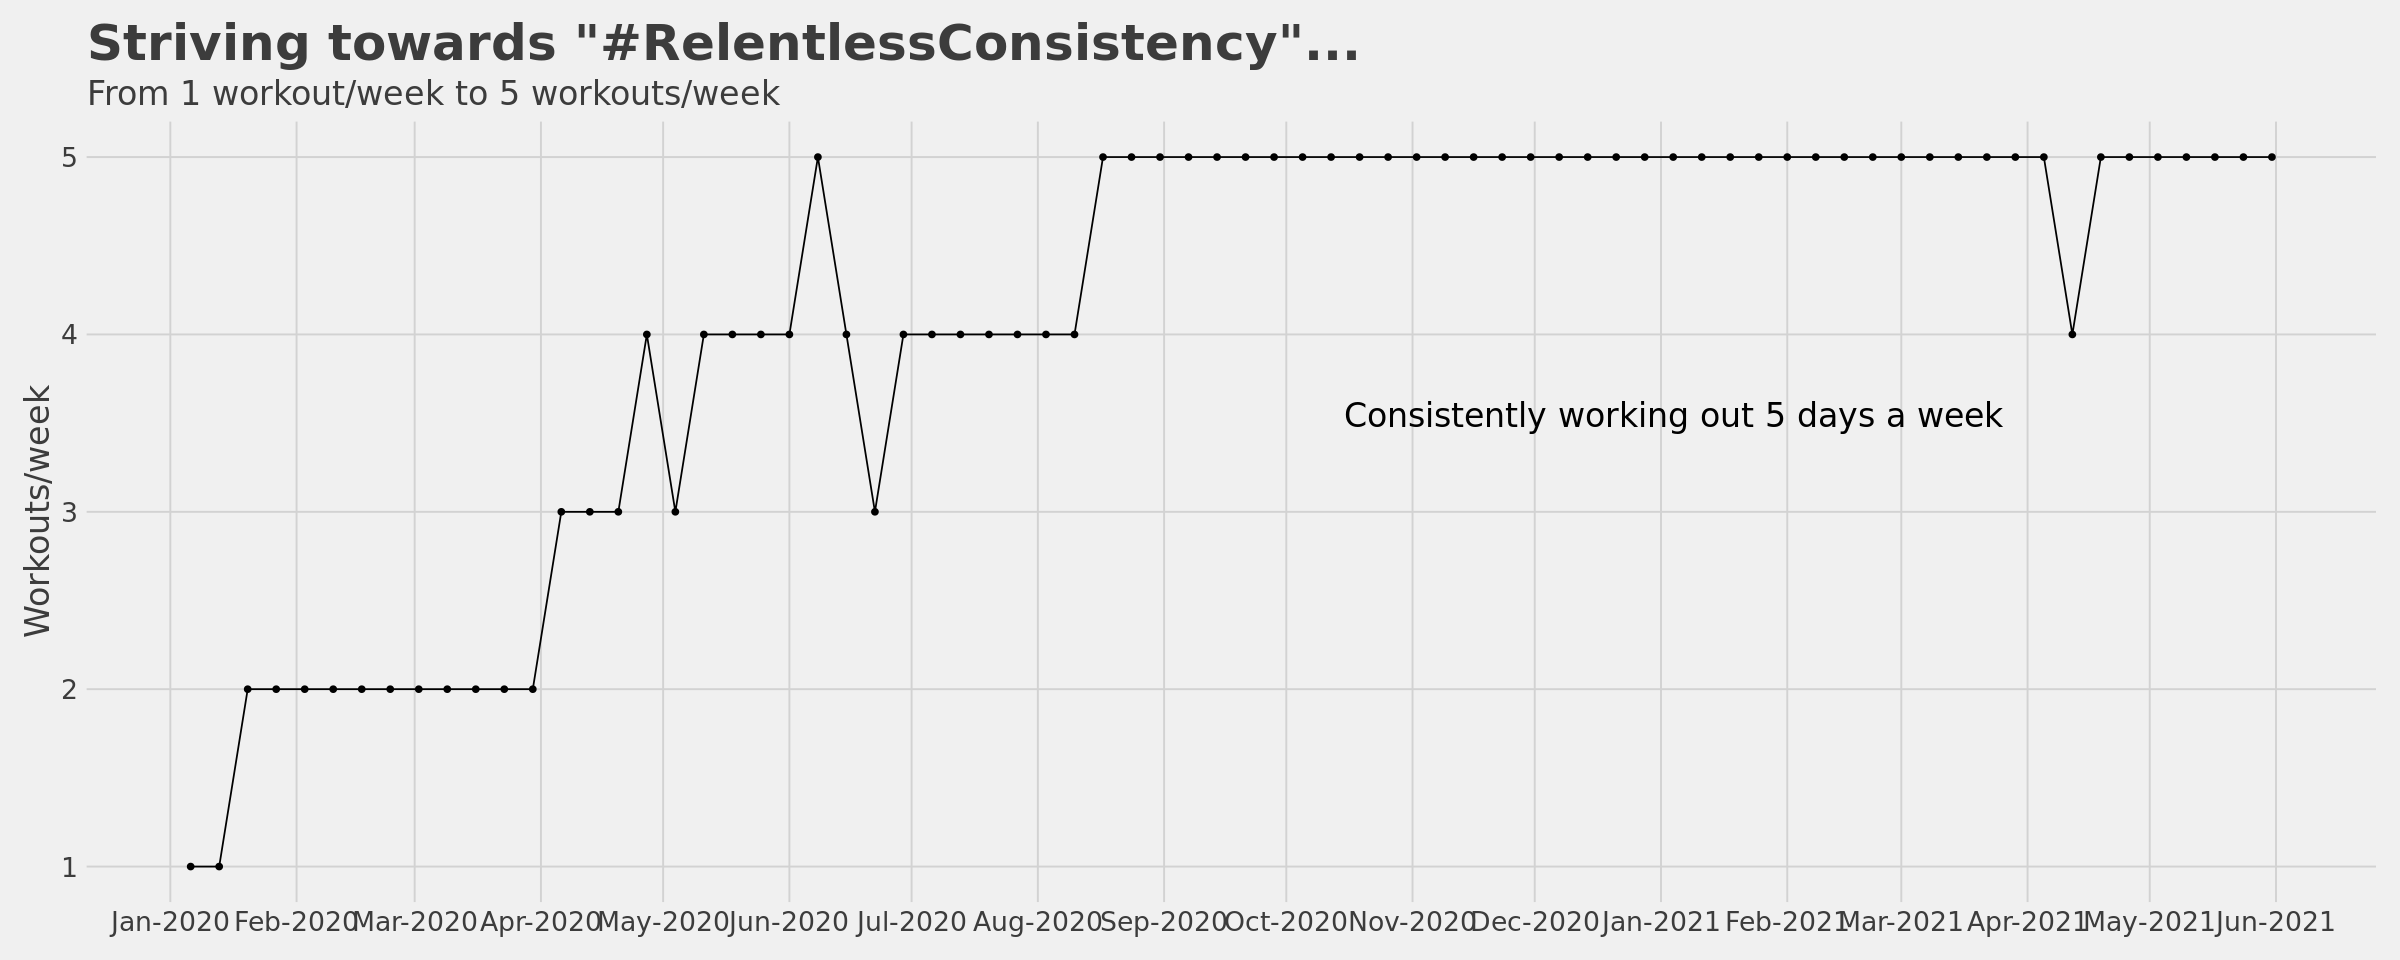

In [113]:
options(repr.plot.width=20, repr.plot.height=8)
df_5_days_a_week <- df_workouts_per_week %>%
  mutate(week=ymd(week)) %>%
  filter(n==5)
title <- "Striving towards \"#RelentlessConsistency\"..."
subtitle <- "From 1 workout/week to 5 workouts/week"
p <- df_workouts_per_week %>%
  filter(ymd(week) != max(ymd(week))) %>%
  ggplot(aes(x=ymd(week), y=n)) +
  geom_point() + 
  geom_line() +
  annotate("text", x=min(df_5_days_a_week$week)+210, y=3.55, label="Consistently working out 5 days a week", size=7) +  
  #geom_smooth("loess") +
  scale_y_continuous(breaks=seq(1,6,1)) +
  scale_x_date(date_breaks = "1 month", date_labels="%b-%Y") +
  theme_fivethirtyeight() + 
  labs(title=title,
       subtitle=subtitle) +
  theme(legend.position="none") +
  theme(axis.title = element_text(), axis.title.x = element_blank(), text = element_text(size=20)) + 
  ylab('Workouts/week')
p

In [114]:
library(grid)
library(pBrackets) 
bracketsGrob <- function(...){
l <- list(...)
e <- new.env()
e$l <- l
  grid:::recordGrob(  {
    do.call(grid.brackets, l)
  }, e)
}

# note that units here are "npc", the only unit (besides physical units) that makes sense
# when annotating the plot panel in ggplot2 (since we have no access to 
# native units)

b1 <- bracketsGrob(0.33, 0.05, 0, 0.05, h=0.05, lwd=2, col="red")
b1 <- bracketsGrob(x2=0.45, y2=0.70, x1=0.95, y1=0.70, h=0.05, lwd=2, col="red")

p2 <- p + 
  annotation_custom(b1)
p2

ERROR: Error in library(pBrackets): there is no package called ‘pBrackets’


In [ ]:
df_wt <- read_csv(file.path("data", "Amit.csv"))
head(df_wt)

In [ ]:
df_wt2 <- df_wt %>%
  select(Date, Weight) %>%
  mutate(Weight = as.integer(Weight/10)*10) %>%
  count(Weight) %>%
  mutate(Weight = glue("{Weight}s ({n} days)"))
df_wt2

In [ ]:
library(waffle)
library(ggtext)
text_col <- "#d0cfcd"
light_col <- "#fff1af"
dark_col <- "#585350"
title_col <- "#fc8431"
text_col <- "#d0cfcd"
bg_col <- "#0d101f"
p2_days_counts_as_list <- unlist(df_wt2$n)
names(p2_days_counts_as_list) <- df_wt2$Weight
title <- glue("Journey to losing 61lb in {sum(p2_days_counts_as_list)} days, from {as.integer(max(df_wt$Weight))}lb to {as.integer(min(df_wt$Weight))}lb")
subtitle <- glue("1 box = 1 day")
waffle(
  p2_days_counts_as_list, rows=10, size = 0.5, legend_pos = "bottom",
  #colors = c("#c7d4b6", "#a3aabd", "#a0d0de"),
  title = glue("{title}\n{subtitle}")) + 
theme(text = element_text(size=28)) +
theme(plot.title = element_text(size=28, family="Helvetica Bold")) +
guides(fill = guide_legend(nrow = 1)) +
  ggthemes::scale_fill_tableau(name=NULL) 